In [ ]:
!pip install folium

In [1]:
# import required modules
import pandas as pd
import numpy as np
from dask import dataframe as dd
import holidays
from datetime import datetime
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium
from folium.plugins import MarkerCluster,  FastMarkerCluster
import nltk
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge


# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_pickle(r'C:\Course\Repo\Fraud detection\Files\df_model_data_after_DataCleansing_21.3.25.pkl')

## 📊 Visualization of Unused Data for Modeling

#### <font color='Indigo'>📍 Map of Customer Transactions

In [5]:
# Add a marker cluster to the map
#marker_cluster = MarkerCluster().add_to(map_ams)

df_geo = pd.read_pickle(r'C:\Course\Repo\Fraud detection\Files\df_geo_features_after_data_prep_8.3.25.pkl')

lats = df_geo['lat'].tolist()
lons = df_geo['long'].tolist()
locations = list(zip(lats, lons))

# Create a base map
map1 = folium.Map(location=[39.8283, -98.5795], zoom_start=10)
FastMarkerCluster(data=locations).add_to(map1)
map1

#### <font color='Indigo'>WORD CLOUD

In [10]:
df_text = pd.read_pickle(r'C:\Course\Repo\Fraud detection\Files\df_text_features_after_data_prep_8.3.25.pkl')

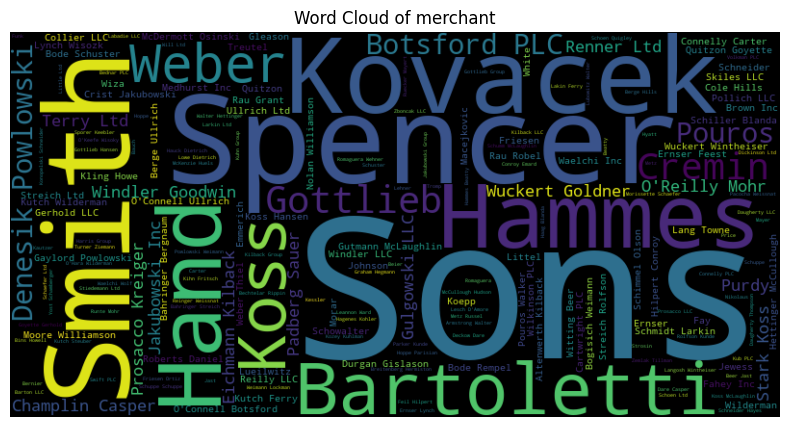

In [12]:
#creating the word cloud
text_data = df_text['merchant'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of merchant")
plt.show()

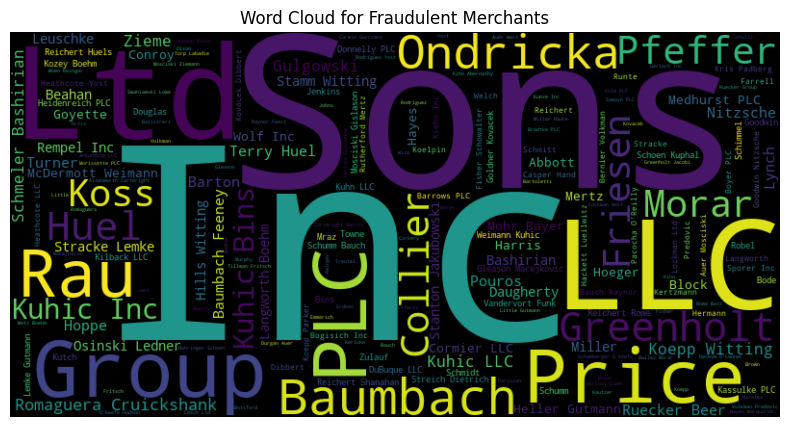

In [13]:
merged_df = pd.merge(df, df_text, on='trans_num', how='inner')
#creating the word cloud
text_data = merged_df[merged_df['is_fraud'] == 1]['merchant'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Fraudulent Merchants")
plt.show()

####  <font color='blue'> Summary of Word Cloud Analysis for Credit Card Fraud Modeling

- **Naming Patterns**: Non-fraudulent merchants often use personal names (e.g.,"KOVACEK", "SMITH," "WEBER"), suggesting small, legitimate businesses, while fraudulent merchants prefer corporate terms (e.g., "INC," "GROUP") to seem credible or conceal their identity.
- **Overlap**: Names like "SONS", "KOSS" and "MORAR" appear in both groups, hinting at mixed activities or misclassification.
- **Fraud Detection Insights**: Corporate names may signal fraud, and mixed-activity merchants need closer review. Adding name-based features to models could boost accuracy.
- **Limitations**: The analysis focuses on frequency and requires more data for deeper validation.

This highlights key differences in merchant naming and their implications for improving fraud detection.

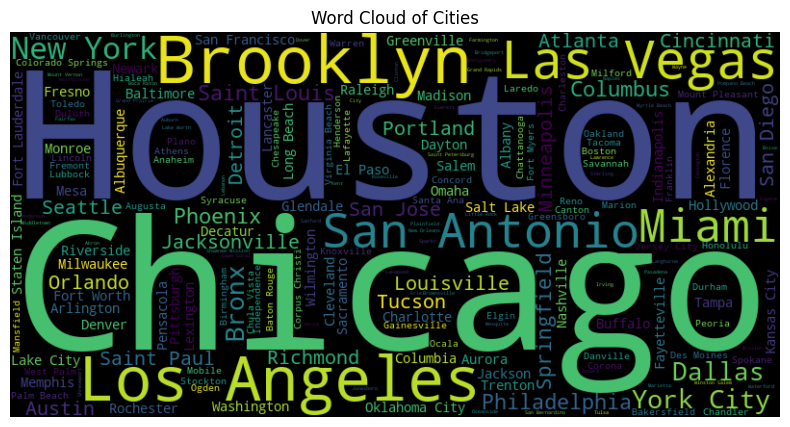

In [15]:
#creating the word cloud
text_data = df_text['city'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cities")
plt.show()

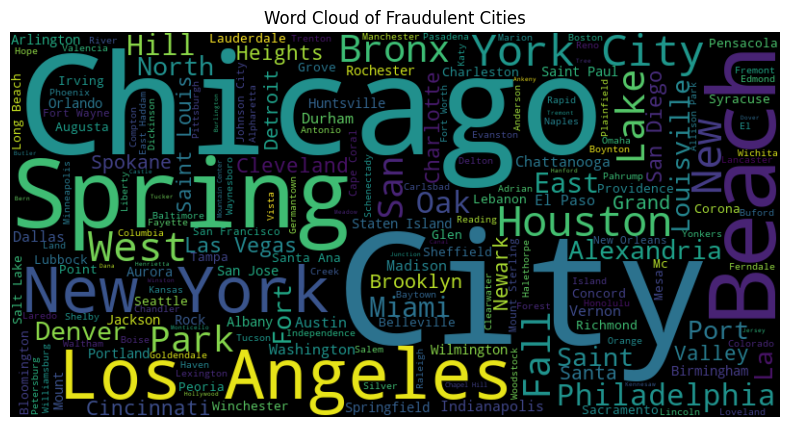

In [16]:
merged_df = pd.merge(df, df_text, on='trans_num', how='inner')
#creating the word cloud
text_data = merged_df[merged_df['is_fraud'] == 1]['city'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Fraudulent Cities")
plt.show()

####  <font color='blue'> Summary of City Word Cloud Analysis for Credit Card Fraud Modeling

- **Similar Distributions**: Both word clouds (all transactions and fraudulent transactions) feature nearly identical cities, with major cities like Los Angeles, Chicago, and New York dominating in both.
- **No Distinct Patterns**: Unlike merchant names, which showed clear differences (e.g., personal vs. corporate), city names lack distinguishing features for fraud detection.
- **Limited Predictive Power**: City alone does not offer strong signals for fraud, as fraud scales with transaction volume across cities.
- **Implications for Modeling**: City may have limited standalone value but could be useful when combined with other features (e.g., merchant type or transaction amount).

This analysis suggests that city names are less informative for fraud detection compared to merchant names, with fraud patterns closely mirroring overall transaction volumes.

## Add new features 

#### <font color='Indigo'>add card_brand and card_type from credit card number

In [18]:
##### helper function to get issuer and card type from credit card number 

def identify_card(card_number: str) -> dict:
    """
    Identify card type and brand from card number using BIN patterns
    Returns dictionary with card_type and brand
    """
    # Remove any spaces or non-digit characters
    card_number = ''.join(filter(str.isdigit, str(card_number)))
    
    # Check if card number is valid length
    if not (12 <= len(card_number) <= 19):
        return {"card_type": "Invalid", "brand": "Unknown"}
    
    # Common card patterns using first few digits (BIN)
    card_patterns = {
        "4": {"brand": "Visa", "card_type": "Credit"}, 
        "4026": {"brand": "Visa Electron", "card_type": "Debit"},
        "414170": {"brand": "Visa Rewards", "card_type": "Credit"},
        "4571": {"brand": "Visa Debit", "card_type": "Debit"}, 
        "4929": {"brand": "Visa Purchase", "card_type": "Credit"}, 
        "4908": {"brand": "Visa Platinum", "card_type": "Credit"}, 
        "4910": {"brand": "Visa Gold", "card_type": "Credit"},  
        "50": {"brand": "Maestro", "card_type": "Debit"},
        "56": {"brand": "Maestro", "card_type": "Debit"},
        "57":  {"brand": "Maestro", "card_type": "Debit"},
        "58":  {"brand": "Maestro", "card_type": "Debit"},           
        "51": {"card_type": "Credit", "brand": "Mastercard"},
        "52": {"card_type": "Credit", "brand": "Mastercard"},
        "53": {"card_type": "Credit", "brand": "Mastercard"},
        "54": {"card_type": "Credit", "brand": "Mastercard"},
        "55": {"card_type": "Credit", "brand": "Mastercard"},
		"55": {"card_type": "Credit", "brand": "Mastercard"},
        "2221-2720": {"card_type": "Credit", "brand": "Mastercard"},
        "34": {"card_type": "Charge", "brand": "American Express"},
        "37": {"card_type": "Charge", "brand": "American Express"},
        "6011": {"card_type": "Credit", "brand": "Discover"},
        "644-649": {"card_type": "Credit", "brand": "Discover"},
        "65": {"card_type": "Credit", "brand": "Discover"},
		"35": {"brand": "JCB", "card_type": "Credit"}, 
        "30": {"brand": "Diners Club", "card_type": "Credit"},
        "36": {"brand": "Diners Club", "card_type": "Credit"},   
        "38": {"brand": "Diners Club", "card_type": "Credit"},
        "39": {"brand": "Diners Club", "card_type": "Credit"},
        "300-305": {"card_type": "Credit", "brand": "Diners Club"},
        "3095": {"card_type": "Credit", "brand": "Diners Club"},
        "2131": {"brand": "JCB", "card_type": "Credit"}, 
        "1800": {"brand": "JCB", "card_type": "Credit"}, 
        "62": {"card_type": "Credit", "brand": "UnionPay"},
        "5018": {"card_type": "Debit", "brand": "Maestro"},
        "5020": {"card_type": "Debit", "brand": "Maestro"},
        "5038": {"card_type": "Debit", "brand": "Maestro"},
        "5893": {"card_type": "Debit", "brand": "Maestro"},
        "6304": {"card_type": "Debit", "brand": "Maestro"},
        "6759": {"card_type": "Debit", "brand": "Maestro"},
        "6761": {"card_type": "Debit", "brand": "Maestro"},
        "6762": {"card_type": "Debit", "brand": "Maestro"},
        "6763": {"card_type": "Debit", "brand": "Maestro"},
         "6":  {"brand": "Maestro", "card_type": "Debit"},
        "637": {"brand": "InstaPayment", "card_type": "Credit"},
        "638": {"brand": "InstaPayment", "card_type": "Credit"},
        "639": {"brand": "InstaPayment", "card_type": "Credit"},
        "622126-622925": {"brand": "Discover", "card_type": "Credit"}
    }
    
    # Prepaid patterns
    prepaid_patterns = {
        "604": {"card_type": "Prepaid", "brand": "Visa Gift Card"},
        "5100": {"card_type": "Prepaid", "brand": "Mastercard"}
    }
    
    # Check prepaid first
    for prefix, info in prepaid_patterns.items():
        if card_number.startswith(prefix):
            return info
    
    # Then general patterns
    for prefix, info in card_patterns.items():
        if "-" in prefix:  # Handle ranges
            start, end = prefix.split("-")
            if len(prefix) <= len(card_number):
                card_start = card_number[:len(start)]
                if start <= card_start <= end:
                    return info
        else:
            if card_number.startswith(prefix):
                return info
    
    return {"card_type": "Unknown", "brand": "Unknown"}

def validate_card(card_number: str) -> bool:
    """
    Validate card number using Luhn algorithm
    """
    digits = [int(x) for x in str(card_number) if x.isdigit()]
    if not digits:
        return False
        
    checksum = 0
    even = False
    for digit in digits[::-1]:
        if even:
            doubled = digit * 2
            checksum += doubled if doubled <= 9 else doubled - 9
        else:
            checksum += digit
        even = not even
        
    return checksum % 10 == 0

def add_cc_info(df: pd.DataFrame, cc_column: str = 'cc_num') -> pd.DataFrame:
    """
    Update a DataFrame with card type, brand, and validity information
    """
    # Ensure cc_num is string type
    df[cc_column] = df[cc_column].astype(str)
    
    # Apply card identification
    card_info = df[cc_column].apply(identify_card)
    
    # Extract type and brand into new columns
    df['card_type'] = card_info.apply(lambda x: x['card_type'])
    df['card_brand'] = card_info.apply(lambda x: x['brand'])
    
    return df


In [20]:
df = add_cc_info(df, 'cc_num')

#####  <font color='blue'> view card brand And Type distribution 

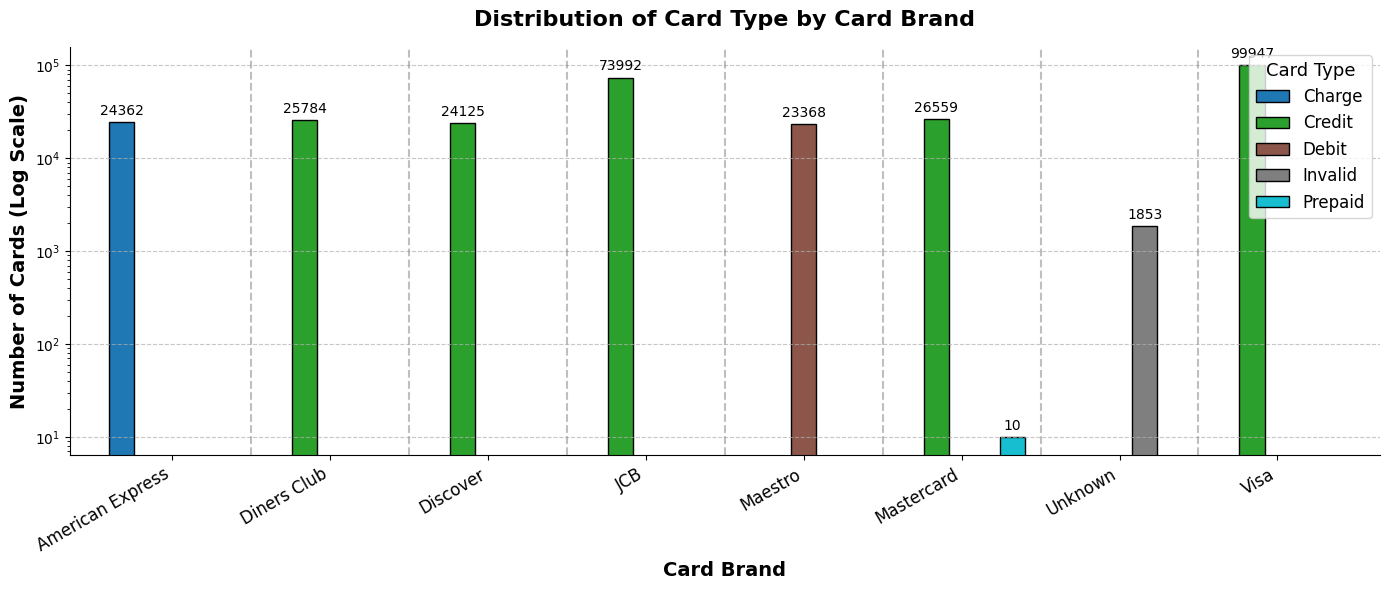

In [23]:
# Group by card_brand and card_type and count the occurrences
card_counts = df.groupby(['card_brand', 'card_type']).size().unstack().fillna(0)

# Create the figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the grouped bar chart
card_counts.plot(kind='bar', stacked=False, cmap='tab10', ax=ax, width=0.8, edgecolor='black')

# Apply logarithmic scale to y-axis
ax.set_yscale('log')

# Add labels and title
ax.set_xlabel('Card Brand', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Cards (Log Scale)', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Card Type by Card Brand', fontsize=16, fontweight='bold', pad=15)

# Improve tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical separators between brands
xticks = ax.get_xticks()
for i in range(len(xticks) - 1):
    ax.axvline(x=(xticks[i] + xticks[i + 1]) / 2, color='gray', linestyle='--', alpha=0.5)

# Add legend with better placement
ax.legend(title='Card Type', fontsize=12, title_fontsize=13, loc='upper right', frameon=True)

# Remove unnecessary border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, label_type='edge', padding=3, color='black')

# Show the plot
plt.tight_layout()
plt.show()


##### <font color='blue'> plot fraud by card_brnd

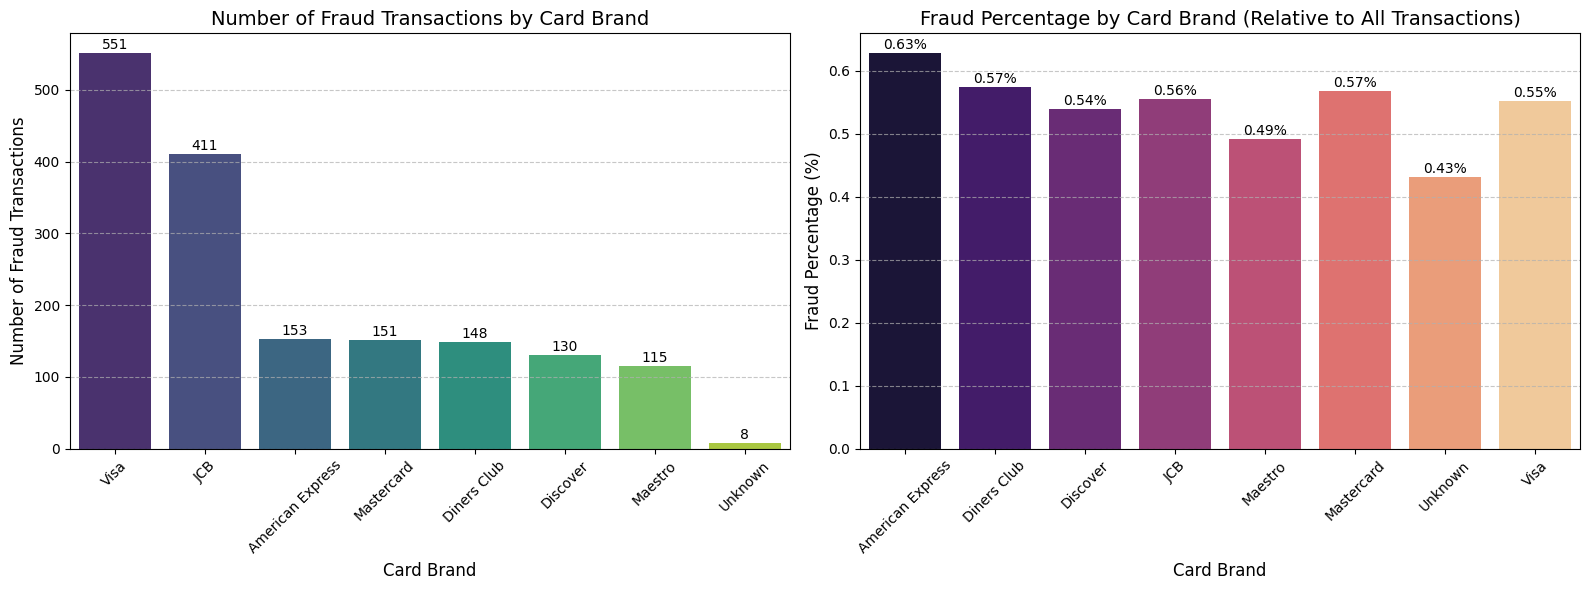

In [25]:
# Group by card_brand and count the number of fraud transactions
fraud_counts = df[df['is_fraud'] == 1]['card_brand'].value_counts()

# Group by card_brand and count the total number of transactions (fraud + non-fraud) for each brand
total_counts = df['card_brand'].value_counts()

# Calculate the fraud percentage for each card brand (fraud transactions / total transactions for the brand) * 100
fraud_percentages = (fraud_counts / total_counts) * 100

# Replace NaN with 0 in fraud_percentages for card brands with no frauds
fraud_percentages = fraud_percentages.fillna(0)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First Plot: Number of fraud transactions by card brand
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Card Brand', fontsize=12)
axes[0].set_ylabel('Number of Fraud Transactions', fontsize=12)
axes[0].set_title('Number of Fraud Transactions by Card Brand', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Show values on bars for the first plot
for index, value in enumerate(fraud_counts.values):
    axes[0].text(index, value + max(fraud_counts.values) * 0.01, f"{value:,}", ha='center', fontsize=10)

# Second Plot: Fraud percentage by card brand (relative to all transactions)
sns.barplot(x=fraud_percentages.index, y=fraud_percentages.values, palette='magma', ax=axes[1])
axes[1].set_xlabel('Card Brand', fontsize=12)
axes[1].set_ylabel('Fraud Percentage (%)', fontsize=12)
axes[1].set_title('Fraud Percentage by Card Brand (Relative to All Transactions)', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show values on bars for the second plot
for index, value in enumerate(fraud_percentages.values):
    axes[1].text(index, value + max(fraud_percentages.values) * 0.01, f"{value:.2f}%", ha='center', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#### <font color='Indigo'>Time Since Last Transaction (per acct_num)

In [27]:
import numpy as np
import pandas as pd

# Sort the DataFrame by acct_num and unix_time
df = df.sort_values(by=['acct_num', 'unix_time'])

# Calculate the time difference in seconds between consecutive transactions per account
df['time_since_last_trans'] = df.groupby('acct_num')['unix_time'].diff()

# For the first transaction of each account, set time_since_last to 8760 hours (in seconds)
# 8760 hours * 3600 seconds/hour = 31,536,000 seconds
df['time_since_last_trans'] = df['time_since_last_trans'].fillna(8760 * 3600)

# Convert time_since_last from seconds to hours
df['time_since_last_trans'] = df['time_since_last_trans'] / 3600

# Round to nearest integer and convert to nullable integer type ('Int64') for compatibility with NaN values if any
df['time_since_last_trans'] = df['time_since_last_trans'].round().astype('Int64')

# Preview the result
print(df[['acct_num', 'unix_time', 'time_since_last_trans']].head())



        acct_num   unix_time  time_since_last_trans
77650   18374117  1578111564                   8760
109029  18374117  1578432868                     89
186167  18374117  1582927178                   1248
139786  18374117  1583630169                    195
69336   18374117  1584313076                    190


In [29]:
time_since_last_trans_min = df['time_since_last_trans'].min()
time_since_last_trans_max = df['time_since_last_trans'].max()

print(f"time_since_last_trans: {time_since_last_trans_min} - {time_since_last_trans_max}")

time_since_last_trans: 0 - 8760


#### <font color='Indigo'>Z-score of amt per Account
This feature measures how many standard deviations an amt is from the mean for each account.

In [31]:
# Calculate mean and standard deviation of amt per acct_num
amt_stats = df.groupby('acct_num')['amt'].agg(['mean', 'std']).rename(columns={'mean': 'amt_mean', 'std': 'amt_std'})

# Merge these statistics back to the original DataFrame
df = df.merge(amt_stats, on='acct_num', how='left')

# Calculate Z-score: (amt - mean) / std
df['amt_zscore'] = ((df['amt'] - df['amt_mean']) / df['amt_std']).round(1)

# Handle cases where std is 0 (e.g., all amounts are the same) by filling NaN with 0
df['amt_zscore'] = df['amt_zscore'].fillna(0)

# Drop the unnecessary columns from df
df = df.drop(['amt_mean', 'amt_std'], axis=1)

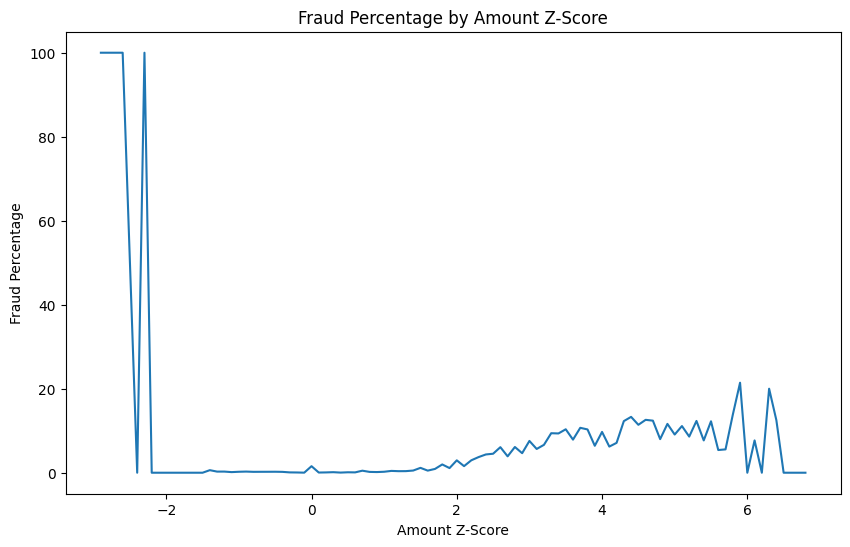

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original code to generate category_stats
category_stats = (
    df.groupby('amt_zscore')
      .agg(total_transactions=('amt_zscore', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index()
      .sort_values(by='amt_zscore', ascending=False)
)

# Add Fraud Percentage column
category_stats['fraud_percentage'] = (category_stats['total_fraud'] / category_stats['total_transactions']) * 100

# Sort by 'amt_zscore' in ascending order for plotting
category_stats = category_stats.sort_values(by='amt_zscore')

# Create the line plot
plt.figure(figsize=(10, 6))  # Set figure size for readability
sns.lineplot(data=category_stats, x='amt_zscore', y='fraud_percentage')

# Add labels and title
plt.xlabel('Amount Z-Score')
plt.ylabel('Fraud Percentage')
plt.title('Fraud Percentage by Amount Z-Score')

# Display the plot
plt.show()

#### <font color='Indigo'>Number of Transactions in the Last 24 Hours (per acct_num)

In [39]:
# Assuming df is your DataFrame with 'unix_time' and 'acct_num' columns

# If 'trans_datetime' is in the index, reset the index
if df.index.name == 'trans_datetime' or ('trans_datetime' in df.index.names):
    df = df.reset_index(drop=True)

# Remove the existing 'trans_datetime' column if it exists
if 'trans_datetime' in df.columns:
    df = df.drop(columns=['trans_datetime'])

# Convert 'unix_time' to datetime and create a new 'trans_datetime' column
df['trans_datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# Sort the DataFrame by 'acct_num' and 'trans_datetime'
df = df.sort_values(by=['acct_num', 'trans_datetime'])

# Add a column of ones to represent each transaction
df['transaction'] = 1

# Compute rolling count of transactions in the last 24 hours per acct_num
df['trans_last_24h'] = df.groupby('acct_num', group_keys=False).apply(
    lambda x: x.rolling(window='24H', on='trans_datetime')['transaction'].sum()
)

# Subtract 1 to exclude the current transaction from the count
df['trans_last_24h'] = df['trans_last_24h'] - 1

# Reset the index to a clean default integer index
df = df.reset_index(drop=True)


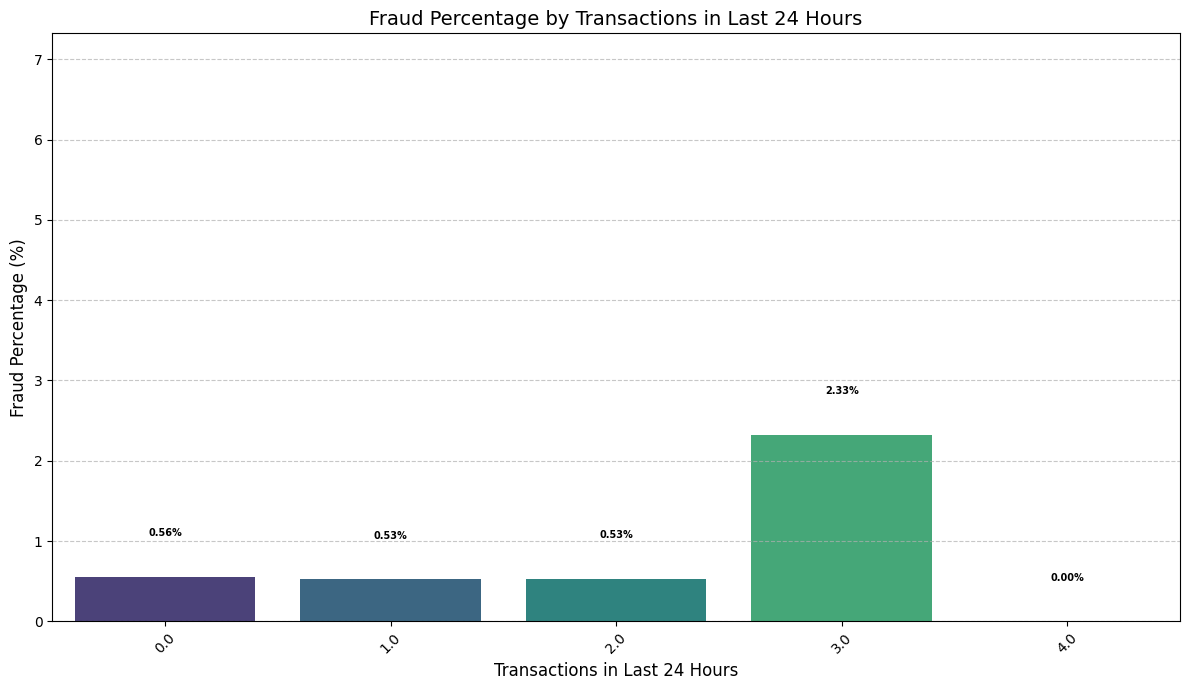

In [40]:
# Assuming 'df' is your DataFrame with the data
# Calculate fraud percentage by category
category_stats = (
    df.groupby('trans_last_24h')
      .agg(total_transactions=('trans_last_24h', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index()
)
category_stats['fraud_percentage'] = (category_stats['total_fraud'] / category_stats['total_transactions']) * 100

# Sort by fraud percentage for better visualization
category_stats = category_stats.sort_values('fraud_percentage')

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='trans_last_24h', y='fraud_percentage', data=category_stats, palette='viridis')

# Add percentage values on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,  # Center of the bar
        height + 0.5,                     # Slightly above the bar
        f"{height:.2f}%",                 # Percentage with 2 decimal places
        ha='center',                      # Horizontal alignment: center
        fontsize=7,                       # Font size
        fontweight='bold'                 # Bold text
    )

# Adjust y-axis limit to ensure text is visible
max_height = category_stats['fraud_percentage'].max()
ax.set_ylim(0, max_height + 5)

# Customize the plot
plt.xlabel('Transactions in Last 24 Hours', fontsize=12)
plt.ylabel('Fraud Percentage (%)', fontsize=12)
plt.title('Fraud Percentage by Transactions in Last 24 Hours', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## Feature Selection

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ssn                    300000 non-null  int32         
 1   cc_num                 300000 non-null  object        
 2   gender                 300000 non-null  int32         
 3   state                  300000 non-null  string        
 4   zip                    300000 non-null  int64         
 5   city_pop               300000 non-null  int64         
 6   job                    300000 non-null  string        
 7   acct_num               300000 non-null  int64         
 8   profile                300000 non-null  string        
 9   trans_num              300000 non-null  string        
 10  trans_time             300000 non-null  int32         
 11  unix_time              300000 non-null  int64         
 12  category               300000 non-null  stri

In [48]:
# Drop the duplicate or uniq columns from df
df = df.drop(['zip', 'cc_num', 'trans_num', 'trans_time', 'unix_time', 'trans_datetime', 'transaction'], axis=1)

# Identify object (categorical) columns
categorical_cols =[ 'state', 'job', 'profile', 'category', 'trans_time_group', 'card_type', 'card_type', 'card_brand']

# Initialize LabelEncoder
le = LabelEncoder()

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [50]:
y=df['is_fraud']
X = df.drop(columns=['is_fraud'])

In [52]:
# Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

# Fit Ridge model
ridge = Ridge(alpha=0.01).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

gb = GradientBoostingClassifier().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected, 
    'SVM': svm_selected,
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'SVM', 'GradientBoost', 'RandomForest','Ridge']].sum(axis=1)

# Output the results
print(selection_df)

                  Feature  Lasso  SVM  GradientBoost  RandomForest  Ridge  Sum
0                     ssn      1    1              1             1      1    5
1                  gender      0    0              1             1      1    3
2                   state      0    1              1             1      1    4
3                city_pop      1    1              1             1      1    5
4                     job      0    1              0             1      1    3
5                acct_num      1    0              1             1      1    4
6                 profile      0    1              1             1      1    4
7                category      0    1              1             1      1    4
8                     amt      1    1              1             1      1    5
9             distance_km      0    1              1             1      1    4
10                    age      1    1              1             1      1    5
11            trans_month      0    1              1

In [54]:
 #Selecting variables with a sum of selections >= 4
final_var = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()
df_model = df[final_var].copy()
df_model['is_fraud'] = df['is_fraud'].copy()

# Output the result to verify
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ssn                    300000 non-null  int32  
 1   state                  300000 non-null  int32  
 2   city_pop               300000 non-null  int64  
 3   acct_num               300000 non-null  int64  
 4   profile                300000 non-null  int32  
 5   category               300000 non-null  int32  
 6   amt                    300000 non-null  float64
 7   distance_km            300000 non-null  int64  
 8   age                    300000 non-null  int32  
 9   trans_month            300000 non-null  int32  
 10  trans_day              300000 non-null  int32  
 11  trans_time_group       300000 non-null  int32  
 12  card_type              300000 non-null  int64  
 13  card_brand             300000 non-null  int32  
 14  time_since_last_trans  300000 non-nu

## Pickle file

In [57]:
df_model.to_pickle(r'C:\Course\Repo\Fraud detection\Files\df_model_data_after_FeatureEngineering_23.3.25.pkl')

#### <br> <br>
## 🛠️ Feature Engineering & Feature Selection Summary for Credit Card Fraud Detection

## Feature Engineering

### Derived Features
- **Geographic Visualizations**  
  - Mapped customer locations using latitude and longitude.
  - Generated word clouds for merchants and cities (both fraudulent and non-fraudulent) to visually assess differences.
  
- **New Feature Creation**  
  - **Card Brand and Card Type:** Extracted and engineered new features from credit card numbers.
  - **Time Since Last Transaction:** Computed the difference in hours between consecutive transactions per account to capture customer behavior.
  - **Transaction Statistics:** Calculated statistical aggregates (mean, standard deviation) of transaction amounts per account, enabling the computation of Z-scores to detect anomalies.

---

## Feature Selection

- **Categorical Encoding**  
  - Applied one-hot encoding to categorical variables (e.g., merchant, card brand) to ensure they are model-ready.

### 1. Model-Based Feature Selection
Five distinct models were used to assess and rank feature importance:
- **Lasso (L1 Regularization):** Shrinks less important coefficients to zero, effectively selecting features.
- **SVM with L1 Penalty:** Utilizes L1 regularization to perform inherent feature selection.
- **Gradient Boosting Classifier:** Ranks features based on their contribution to predictive performance.
- **Random Forest Classifier:** Evaluates features by measuring the reduction in impurity.
- **Ridge (L2 Regularization):** Examines non-zero coefficients, serving as a reference even though it does not zero-out features.

For each model, features were labeled as selected (1) or not selected (0) based on their coefficients or importance scores.

### 2. Aggregation of Selection Results
- A summary DataFrame was constructed aggregating feature selection results across all five models.
- The total selection count for each feature was calculated.

### 3. Final Feature Selection
- Features selected by at least 4 out of the 5 models (i.e., a sum ≥ 4) were retained.
- The final feature set includes:
  - `ssn`
  - `state`
  - `city_pop`
  - `acct_num`
  - `profile`
  - `category`
  - `amt`
  - `distance_km`
  - `age`
  - `trans_month`
  - `trans_day`
  - `trans_time_group`
  - `card_type`
  - `card_brand`
  - `time_since_last_trans`
  - `amt_zscore`

### 4. Dataset Preparation
- A refined DataFrame, `df_model`, was created containing the selected features along with the target variable `is_fraud`.
- This optimized dataset was saved as a pickle file:  
  `df_model_data_after_FeatureEngineering_23.3.25.pkl`.

---

## Conclusion
The feature engineering process transformed raw data into a machine learning-ready format through robust derivation of temporal, geographic, and statistical features, as well as appropriate categorical encoding. The ensemble of model-based feature selection methods identified 15 key features most predictive of credit card fraud. Although the feature `trans_last_24h` was initially considered, it received the lowest score during the selection process and was ultimately excluded from the final model. Overall, this refined dataset is well-optimized for training and evaluating downstream fraud detection models, balancing model complexity with predictive power.

